In [6]:
!git clone https://github.com/PonyGE/PonyGE2.git

fatal: destination path 'PonyGE2' already exists and is not an empty directory.


In [7]:
!cd PonyGE2/ && git pull

Already up to date.


In [8]:
#pip installs

%pip install numpy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
%pip install sewar


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
%pip install openpyxl


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
import shutil
import os

experiment = "regression"

def run_experiment():
    shutil.copy(f"./fitness/{experiment}.py", "./PonyGE2/src/fitness/")
    captured = !cd ./PonyGE2/src && python ponyge.py --parameters ../../parameters/{experiment}.txt
    os.remove(f"./PonyGE2/src/fitness/{experiment}.py")
    
    return captured


In [13]:
import torch
import torch.nn.functional as F
import numpy as np
from sewar.full_ref import mse
from openpyxl import load_workbook
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def extremeVal(reference, val):
    if (val > 1e2*reference) or (val < -1e2*reference):
        return 0
    else:
        return val

split_type_index = {"arima": 2, "sarima": 1}
models_values_column = {
    "arima": {
        "series": 1,
        "arima": 3,
        "mlp": 4,
        "svr": 5,
        "rbf": 6,
    },
    "sarima": {
        "series": 6,
        "sarima": 2,
        "mlp": 3,
        "svr": 4,
        "rbf": 5,
    },
}

def load_data(dataset_name, dataset_path, linear_type):
    wb = load_workbook(dataset_path)
    dataset_name_arr = [dataset_name]

    dataset = {}
    for name in dataset_name_arr:

        ws = wb[name]
        columns = [ws["A"], ws["B"], ws["C"],
                    ws["D"], ws["E"], ws["F"], ws["G"]]

        sheet = [[] for _ in range(len(columns[0]))]

        for c in columns:
            for index, item in enumerate(c):
                sheet[index].append(item.value)

        sheet = np.array(sheet)
        dataset[name] = {"raw": sheet}

    for name, _ in dataset.items():
        sheet = dataset[name]["raw"]

        dataset[name]["series"] = {
            "treino": [], "teste": [], "validacao": []}
        dataset[name][linear_type] = {
            "treino": [], "teste": [], "validacao": []}
        dataset[name]["mlp"] = {"treino": [], "teste": [], "validacao": []}
        dataset[name]["svr"] = {"treino": [], "teste": [], "validacao": []}
        dataset[name]["rbf"] = {"treino": [], "teste": [], "validacao": []}

        for row in sheet[1:]:
            split_type = row[split_type_index[linear_type]]
            if linear_type == "arima" and row[4] == None:
                continue
            key = None
            if split_type.lower() == "teste":
                key = "teste"
            elif split_type.lower() == "validacao" or split_type.lower() == "validação":
                key = "validacao"
            elif split_type.lower() == "treinamento":
                key = "treino"
            else:
                continue

            for model_key, val in models_values_column[linear_type].items():
                dataset[name][model_key][key].append(float(row[val]))

        for type_data in ["teste", "treino", "validacao"]:
            dataset[name]["series"][type_data] = np.array(
                dataset[name]["series"][type_data])
            dataset[name][linear_type][type_data] = np.array(
                dataset[name][linear_type][type_data])
            dataset[name]["mlp"][type_data] = np.array(
                dataset[name]["mlp"][type_data])
            dataset[name]["svr"][type_data] = np.array(
                dataset[name]["svr"][type_data])
            dataset[name]["rbf"][type_data] = np.array(
                dataset[name]["rbf"][type_data])

    fixExtreme = np.vectorize(extremeVal)

    for name in dataset.keys():
        reference = np.max(dataset[name]["series"]["treino"])

        for type_data in ["teste", "treino", "validacao"]:
            dataset[name]["mlp"][type_data] = fixExtreme(
                reference, dataset[name]["mlp"][type_data])
            dataset[name]["svr"][type_data] = fixExtreme(
                reference, dataset[name]["svr"][type_data])
            dataset[name]["rbf"][type_data] = fixExtreme(
                reference, dataset[name]["rbf"][type_data])
            dataset[name][linear_type][type_data] = fixExtreme(
                reference, dataset[name][linear_type][type_data])

    return dataset[dataset_name]


def build_model(phenotype):
    model = {"window_size": 0, "linear": {}, "nlinear": {}}

    window_size, model_phenotype = phenotype.split('~')
    model["window_size"] = int(window_size)

    linear, nlinear = model_phenotype.split(';')

    weight_tuple, linear_model = linear.split(':')

    weight_values = weight_tuple.removeprefix('(').removesuffix(')')
    model["linear"][linear_model] = [
        float(x) for x in weight_values.split(' ')]

    nlinear_parts = nlinear.split(',')

    for i in range(len(nlinear_parts)):
        weight_tuple, nlinear_model = nlinear_parts[i].split(':')
        weight_values = weight_tuple.removeprefix('(').removesuffix(')')

        if nlinear_model in model["nlinear"]:
            model["nlinear"][nlinear_model] += [
                float(x) for x in weight_values.split(' ')]
        else:
            model["nlinear"][nlinear_model] = [
                float(x) for x in weight_values.split(' ')]

    return model

def predict_mse(model, arima_dataset, sarima_dataset, split):
    if "arima" in model["linear"].keys():
        dataset = arima_dataset
        linear_type = "arima"
    else:
        dataset = sarima_dataset
        linear_type = "sarima"

    window_size = model["window_size"]
    predict = dataset["series"][split]
    X_train = apply_window(
        window_size, split, linear_type, dataset, model_names=model["nlinear"].keys())
    kernel = []
    for i in range(window_size):
        for _, val in model["linear"].items():
            kernel.append(val[i])
        for _, val in model["nlinear"].items():
            kernel.append(val[i])
    return mse(create_prediction(X_train, np.reshape(kernel, (1, -1))), predict)

def apply_window(window_size, data_type, linear_type, dataset, model_names=None):
    size_pred = len(dataset["series"][data_type])
    new_data = []
    for w in range(window_size):
        linear = np.concatenate(
            [np.zeros(w), dataset[linear_type][data_type]])
        linear = linear[:size_pred]
        row = np.array(linear)
        for model_name in model_names:
            nonlinear = np.concatenate(
                [np.zeros(w), dataset[model_name][data_type]])
            nonlinear = nonlinear[:size_pred]
            row = np.column_stack([row, nonlinear])
        if len(new_data) == 0:
            new_data = row
        else:
            new_data = np.column_stack([new_data, row])
    return np.array(new_data)

def create_prediction(X, kernel):
    X = torch.tensor(np.expand_dims(X, axis=(0, 1))).float()
    kernel = torch.tensor(np.expand_dims(kernel, axis=(0, 1))).float()
    X.to(device)
    kernel.to(device)
    result = F.conv2d(X, kernel)
    return result.numpy().squeeze().astype("f")


In [14]:
def treat_experiment_return(result, verbose=False):

    dataset_name = ''
    phenotype = ''
    for line in result:
        if "Phenotype: " in line:
            phenotype = line.replace("Phenotype: ", "").strip()
        elif "DATASET_NAME" in line:
            dataset_name = line.replace("DATASET_NAME: ", "")

    if verbose:
        print(f'Dataset: {dataset_name}')
        print(f'Fenótipo: {phenotype}')

    arima_dataset = load_data(dataset_name, './datasets/arima_data.xlsx', 'arima')
    sarima_dataset = load_data(dataset_name, './datasets/sarima_data.xlsx', 'sarima')
    model = build_model(phenotype)
    
    test_prediction = predict_mse(model, arima_dataset, sarima_dataset, 'teste')

    if verbose:
        print('Fitness treino:', f"{predict_mse(model, arima_dataset, sarima_dataset, 'treino'):.3e}")
        print('Fitness validacao:', f"{predict_mse(model, arima_dataset, sarima_dataset, 'validacao'):.3e}")
        print('Fitness test:', f"{test_prediction:.3e}")

    return phenotype, test_prediction

verbose = True
results = []
for i in range(15):
    result = run_experiment()
    results.append(treat_experiment_return(result, verbose))

    if verbose:
        print()
        print('---------------------')
        print()

fitnesses = [x[1] for x in results]
print('Average:', np.average(fitnesses))
print('Std. dev.:', np.std(fitnesses))
print('Best fitness:', np.min(fitnesses))
print('Best model:', results[np.argmin(fitnesses)][0])

Dataset: CARSALES
Fenótipo: 1~(01.00150 45.32249 17.25102 77.49601 32.52330 19.08853 65.50329 72.36611 72.10399 95.46362):sarima;(01.00457 23.77496 14.32523 03.82167 97.65503 91.72366 19.72103 99.98263 02.37749 04.43252):mlp
Fitness treino: 7.254e-04
Fitness validacao: 3.619e-02
Fitness test: 7.840e-02

---------------------



c:\Users\hsabi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sewar\utils.py:18: UserWarning: Supplied images have different dtypes float32 and float64
  warnings.warn(msg)


Dataset: CARSALES
Fenótipo: 1~(00.99999 23.46287 64.52539 59.77049 03.29161 34.36620 54.33874 12.72432 17.65464 00.04262):sarima;(01.00534 60.07262 80.01042 23.80010 55.97788 38.36620 54.33074 01.00558 75.43307 31.27243):mlp
Fitness treino: 7.257e-04
Fitness validacao: 3.609e-02
Fitness test: 7.827e-02

---------------------

Dataset: CARSALES
Fenótipo: 1~(00.99999 71.17512 40.83033 42.34748 58.92770 26.53774 18.11244 26.53616 13.56255 04.34541):sarima;(01.00499 77.06265 77.46121 24.47265 61.60135 25.59043 54.11090 00.49650 33.65612 17.61234):mlp
Fitness treino: 7.257e-04
Fitness validacao: 3.608e-02
Fitness test: 7.823e-02

---------------------

Dataset: CARSALES
Fenótipo: 1~(00.89998 45.33004 35.33220 06.81830 65.13460 89.55703 15.82415 30.74985 06.91217 84.27223):sarima;(00.91412 77.77089 47.94343 25.61920 15.95650 04.87976 06.23007 01.46267 19.40893 13.72659):mlp,(00.38754 89.32137 65.93820 38.70931 24.62295 83.71318 84.27256 22.51342 38.95589 15.82415):svr
Fitness treino: 1.840e-

In [12]:
def run_tests(dataset_name):
    linear_models = ['arima', 'sarima']
    nlinear_models = ['mlp', 'svr', 'rbf']

    for linear_model in linear_models:

        phenotype = f'1~(01.00000 00.00000 00.00000 00.00000 00.00000 00.00000 00.00000 00.00000 00.00000 00.00000):{linear_model};(00.00000 00.00000 00.00000 00.00000 00.00000 00.00000 00.00000 00.00000 00.00000 00.00000):{nlinear_models[0]}'

        print(f'Dataset: {dataset_name}')
        print(f'{linear_model}')

        arima_dataset = load_data(
            dataset_name, './datasets/arima_data.xlsx', 'arima')
        sarima_dataset = load_data(
            dataset_name, './datasets/sarima_data.xlsx', 'sarima')
        model = build_model(phenotype)

        test_prediction = predict_mse(
            model, arima_dataset, sarima_dataset, 'teste')
        print('Fitness treino:',
              f"{predict_mse(model, arima_dataset, sarima_dataset, 'treino'):.3e}")
        print('Fitness validacao:',
              f"{predict_mse(model, arima_dataset, sarima_dataset, 'validacao'):.3e}")
        print('Fitness test:', f"{test_prediction:.3e}")
        print()
        print('------------------')
        print()

        for nlinear_model in nlinear_models:
            phenotype = f'1~(01.00000 00.00000 00.00000 00.00000 00.00000 00.00000 00.00000 00.00000 00.00000 00.00000):{linear_model};(01.00000 00.00000 00.00000 00.00000 00.00000 00.00000 00.00000 00.00000 00.00000 00.00000):{nlinear_model}'

            print(f'Dataset: {dataset_name}')
            print(f'{linear_model} + {nlinear_model}')

            arima_dataset = load_data(dataset_name, './datasets/arima_data.xlsx', 'arima')
            sarima_dataset = load_data(dataset_name, './datasets/sarima_data.xlsx', 'sarima')
            model = build_model(phenotype)

            test_prediction = predict_mse(model, arima_dataset, sarima_dataset, 'teste')
            print('Fitness treino:', f"{predict_mse(model, arima_dataset, sarima_dataset, 'treino'):.3e}")
            print('Fitness validacao:', f"{predict_mse(model, arima_dataset, sarima_dataset, 'validacao'):.3e}")
            print('Fitness test:', f"{test_prediction:.3e}")
            print()
            print('------------------')
            print()


datasets = ['CARSALES', 'Electricity', 'GAS', 'LAKEERIE', 'Nordic', 'PIGS', 'POLLUTION', 'REDWINE', 'SUNSPOT', 'B1H']

for dataset in datasets:
    run_tests(dataset)

Dataset: REDWINE
arima


c:\Users\hsabi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sewar\utils.py:18: UserWarning: Supplied images have different dtypes float32 and float64
  warnings.warn(msg)


Fitness treino: 8.601e-03
Fitness validacao: 1.736e-02
Fitness test: 3.110e-02

------------------

Dataset: REDWINE
arima + svr
Fitness treino: 1.909e-03
Fitness validacao: 8.328e-03
Fitness test: 1.033e-02

------------------

Dataset: REDWINE
arima + mlp
Fitness treino: 3.068e-03
Fitness validacao: 7.635e-03
Fitness test: 9.424e-03

------------------

Dataset: REDWINE
arima + rbf
Fitness treino: 1.041e-02
Fitness validacao: 1.742e-02
Fitness test: 3.028e-02

------------------

Dataset: REDWINE
sarima
Fitness treino: 8.601e-03
Fitness validacao: 1.736e-02
Fitness test: 3.110e-02

------------------

Dataset: REDWINE
sarima + svr
Fitness treino: 1.909e-03
Fitness validacao: 8.328e-03
Fitness test: 1.033e-02

------------------

Dataset: REDWINE
sarima + mlp
Fitness treino: 3.019e-03
Fitness validacao: 7.742e-03
Fitness test: 1.060e-02

------------------

Dataset: REDWINE
sarima + rbf
Fitness treino: 1.409e-02
Fitness validacao: 1.741e-02
Fitness test: 3.083e-02

------------------


In [3]:
%pip install autorank

     ---------------------------------------- 9.2/9.2 MB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ------------------------------------- 233.8/233.8 kB 14.0 MB/s eta 0:00:00
  Running setup.py install for baycomp: started
  Running setup.py install for baycomp: finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  DEPRECATION: baycomp is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559

[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


RankResult(rankdf=
              meanrank    median       mad  ci_lower ci_upper effect_size  \
GE ver3           3.00  0.007095   0.00544  0.000228   0.0776         0.0   
ARIMA + SVR       3.85  0.007350  0.006413  0.000229   0.0194   -0.028923   
SARIMA + SVR      4.50  0.007350  0.006413  0.000229   0.0965   -0.028923   
SARIMA + MLP      6.60  0.009325    0.0075  0.000268   0.0919   -0.229584   
ARIMA + MLP       6.90  0.008830  0.006285  0.000269    0.313   -0.199098   
Babu              7.10  0.006295  0.005876  0.000339    0.033    0.095302   
Oliveira2         7.15  0.007400   0.00556  0.000262   0.0384   -0.037401   
ARIMA             7.75  0.009035   0.00641  0.000437   0.0311    -0.22011   
SARIMA            8.25  0.009035   0.00776  0.000437   0.0803   -0.195266   
Oliveira          8.25  0.010265  0.006465  0.000342   0.0346   -0.357876   
ARIMA + RBF       8.85  0.009375  0.004325  0.000511   0.0303   -0.312936   
SARIMA + RBF      9.60  0.009680  0.007995  0.000504   0.

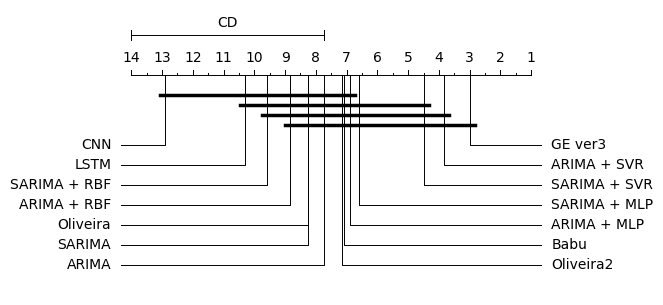

\begin{table}[h]
\centering
\begin{tabular}{lrrllll}
\toprule
{} &     MR &   MED &   MAD &              CI & $\gamma$ &   Magnitude \\
\midrule
GE ver3      &  3.000 & 0.007 & 0.005 &  [0.000, 0.078] &     0.000 &  negligible \\
ARIMA + SVR  &  3.850 & 0.007 & 0.006 &  [0.000, 0.019] &    -0.029 &  negligible \\
SARIMA + SVR &  4.500 & 0.007 & 0.006 &  [0.000, 0.097] &    -0.029 &  negligible \\
SARIMA + MLP &  6.600 & 0.009 & 0.007 &  [0.000, 0.092] &    -0.230 &       small \\
ARIMA + MLP  &  6.900 & 0.009 & 0.006 &  [0.000, 0.313] &    -0.199 &  negligible \\
Babu         &  7.100 & 0.006 & 0.006 &  [0.000, 0.033] &     0.095 &  negligible \\
Oliveira2    &  7.150 & 0.007 & 0.006 &  [0.000, 0.038] &    -0.037 &  negligible \\
ARIMA        &  7.750 & 0.009 & 0.006 &  [0.000, 0.031] &    -0.220 &       small \\
SARIMA       &  8.250 & 0.009 & 0.008 &  [0.000, 0.080] &    -0.195 &  negligible \\
Oliveira     &  8.250 & 0.010 & 0.006 &  [0.000, 0.035] &    -0.358 &       small \\
ARIMA

c:\Users\hsabi\AppData\Local\Programs\Python\Python311\Lib\site-packages\autorank\autorank.py:771: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table_string = table_df.to_latex(float_format=float_format, na_rep='-').strip()


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from autorank import autorank, create_report, plot_stats, latex_table

pd.set_option('display.max_columns', 7)
data = pd.read_csv('./example.csv')

res = autorank(data, alpha=0.05, verbose=False, order='ascending')
print(res)
create_report(res)
plot_stats(res)
plt.show()
latex_table(res)
